In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#import mlflow

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
import sys

# print(sys.executable)
print(sys.version)

3.9.15 (main, Nov 24 2022, 14:39:17) [MSC v.1916 64 bit (AMD64)]


# Weather Forecast with sklearn
### Code of sunshine and snow - _when_ is the winter coming

_D. Tuleva_

_Final Project for Machine Learning September 2023, SoftUni_

<div style="width: 600px; text-align: justify; padding-left: 100px;"> 
    <h4>Abstract</h4>
    
    The goal of this work is to explore different approaches to weather forecasting and create and evaluate a statistical model for short-term single location weather forecast with sklearn.

</div>

### Helper functions

In [4]:
def plot_temp_histograms(dataframe,  binrange = [-30, 22], binwidth = 2.5):
    
    fig, ax = plt.subplots(2,1, figsize=(12, 8))
    
    sns.histplot(dataframe.temp, binwidth=binwidth, binrange=binrange, ax = ax[0], color = "lime")
    sns.histplot(data = dataframe[["tempmin", "tempmax"]], binwidth=binwidth, binrange=binrange, palette = ["blue", "red"], ax = ax[1])
    
    
    ax[0].set_title("Histogram of Avarage Daily Temperature")
    ax[1].set_title("Histogram of Daily Minimum and Maximum Temperature") 
    
    
    ax[0].set_xlabel("")
    ax[1].set_xlabel("Temperature [$^{\circ}$C]")
    ax[0].set_ylabel("Count [n days]")
    ax[1].set_ylabel("Count [n days]")



def plot_temperatures(dataframe, show = True):
    
    plt.figure(figsize=(13, 6))

    plt.plot(dataframe.datetime, dataframe.tempmax, linewidth=0.4, color = "red", label = "Daily Max Temp")
    plt.plot(dataframe.datetime, dataframe.tempmin, linewidth=0.4, color = "blue", label = "Daily Min Temp")
    plt.plot(dataframe.datetime, dataframe.temp, linewidth=1, color = "lime", label = "Daily Avg Temp")

    if show:
        plt.legend()
        plt.show()


def plot_temp_by_year(dataframe, temp_column = "temp"):
    plt.figure(figsize=(13, 6))

    for year in dataframe.datetime.dt.year.unique():
        plt.plot(dataframe.datetime.dt.strftime("%m-%d")[dataframe.datetime.dt.year==year], dataframe.temp[dataframe.datetime.dt.year==year], label = year)
    
    plt.xticks([0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334])
    plt.legend()
    plt.show()

        
def plot_time_series(dataframe, columns):
    if type(columns) == str:
        columns = [columns]
    
    plt.figure(figsize=(12, 6))

    for column_name in columns:
        plt.plot(dataframe.datetime, dataframe[column_name])
   
    plt.show()


def plot_histograms_log_transform(dataframe, column, binwidth = 2, binrange = [0, 60]):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    sns.histplot(sofia_weather_data[column], ax = ax1, binwidth = binwidth, binrange = binrange)
    sns.histplot(sofia_weather_data[column][sofia_weather_data[column] > 0], ax = ax2, binwidth = binwidth, binrange = binrange)
    sns.histplot(np.log1p(sofia_weather_data[column][sofia_weather_data[column] > 0]), ax = ax3)
    
    plt.show()



    
    

### Table of contents

1. [Introduction](#introduction)

2. [Dataset and EDA](#datasets)

3. [Data Preprocessing](#preprocess)

4. [Models](#models)

5. [Conclusion](#conclusion)



<a id="introduction"></a>
## 1. Introduction

Weather forecasting is the process of predicting future atmospheric conditions. Temperature, pressure, humidity, wind speed and direction, cloud cover, and precipitation are the six main components to describe the weather at a given time and location. There are different models and techniques to analyze atmospheric conditions and make predictions. The main types of weather forecasting models are:

 + Numerical Weather Prediction Models - These models use mathematical equations to simulate the behavior of the atmosphere. These models divide the atmosphere into a three-dimensional grid and calculate changes over time based on physical laws.

 + Statistical Models - These models rely on historical weather data and patterns to make predictions. They use relationships between current conditions and past observations to forecast future weather.

 + A combination of both

In our work we attempt to create a model as simple as possible - short-term forecasting for a single-location based on historical weather data using classical  machine learning approach. For our implementation, we utilize [Scikit-learn](https://jmlr.csail.mit.edu/papers/v12/pedregosa11a.html).

<a id="datasets"></a>
## 2. Datasets and EDA

The dataset we use is acquired from [Virtual Crossing](https://www.visualcrossing.com/) - a platform for global forecasts and historical weather data. Documentation and metadata can be found [here](https://www.visualcrossing.com/resources/documentation/weather-data/weather-data-documentation/).

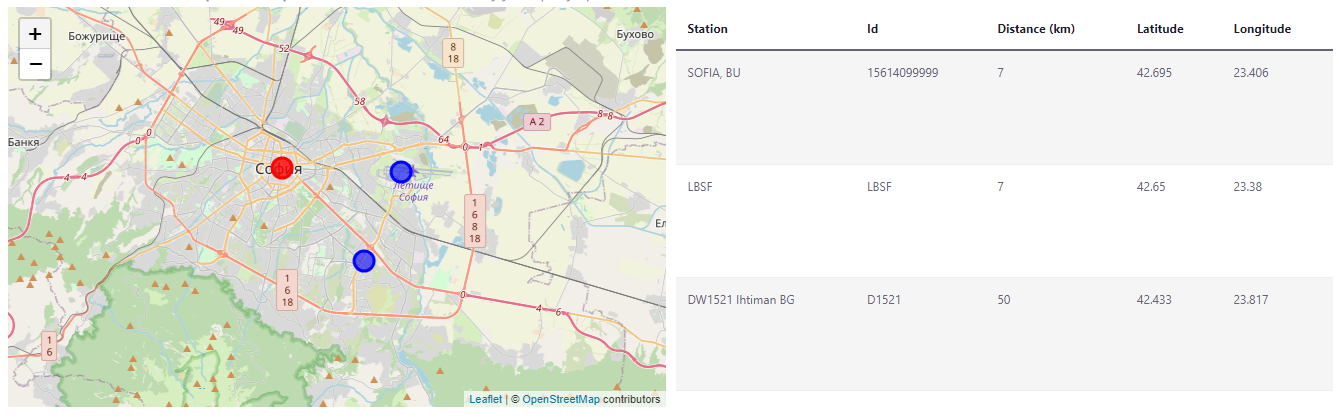

The dataset consists historical data - daily observations on the weather in Sofia, Bulgaria, collected from two stations - SOFIA, BU (NIMH station Sofia) and LBSF (Airport Sofia) from January 2020 to September 2023.

In the following part we explore and visualise our dataset. Some of our feature preprocessing is disscused, but actual preprocessing is done in a pipelines in [this](.WeatherExperiments.ipynb) notebook.

So the data type is float because of the NaNs. Let's explore the missing values:

In [5]:
sofia_weather_data = pd.read_csv("data/Sofia 2021-01-01 to 2023-09-26.csv")

In [6]:
sofia_weather_data.head(2)

,name,datetime,tempmax,tempmin,temp,feelslikemax,feelslikemin,feelslike,dew,humidity,...,solarenergy,uvindex,severerisk,sunrise,sunset,moonphase,conditions,description,icon,stations
0,Sofia,2021-01-01,11.1,-0.9,3.9,11.1,-1.4,3.1,0.1,78.2,...,NaN,NaN,NaN,2021-01-01T07:57:10,2021-01-01T17:03:43,0.58,"Snow, Rain, Partially cloudy",Partly cloudy throughout the day with morning ...,rain,15614099999
1,Sofia,2021-01-02,9.1,-3.9,1.6,7.9,-5.1,0.7,-2.0,78.8,...,NaN,NaN,NaN,2021-01-02T07:57:14,2021-01-02T17:04:36,0.62,Clear,Clear conditions throughout the day.,clear-day,15614099999


In [7]:
sofia_weather_data.shape

(999, 33)

In [8]:
sofia_weather_data.columns

Index(['name', 'datetime', 'tempmax', 'tempmin', 'temp', 'feelslikemax',
       'feelslikemin', 'feelslike', 'dew', 'humidity', 'precip', 'precipprob',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'solarradiation', 'solarenergy', 'uvindex', 'severerisk', 'sunrise',
       'sunset', 'moonphase', 'conditions', 'description', 'icon', 'stations'],
      dtype='object')

`solarradiation`, `solarenergy`, `uvindex` are all missing values, because our request was for station observations only and these are satelite data.

In [9]:
columns_to_keep = [
    "datetime", 
    "tempmax", 
    "tempmin", 
    "temp",
    "dew", 
    "humidity", 
    "precip",
    "precipcover", 
    "preciptype", 
    "snow", 
    "snowdepth", 
    "windgust", 
    "windspeed", 
    "winddir", 
    "sealevelpressure", 
    "cloudcover", 
    "visibility",
    "conditions", 
    "description"
]

In [10]:
sofia_weather_data = sofia_weather_data[columns_to_keep]

In [11]:
sofia_weather_data.dtypes

datetime             object
tempmax             float64
tempmin             float64
temp                float64
dew                 float64
humidity            float64
precip              float64
precipcover         float64
preciptype           object
snow                float64
snowdepth           float64
windgust            float64
windspeed           float64
winddir             float64
sealevelpressure    float64
cloudcover          float64
visibility          float64
conditions           object
description          object
dtype: object

In [12]:
sofia_weather_data.datetime = pd.to_datetime(sofia_weather_data.datetime)

In [13]:
sofia_weather_data.describe().T

,count,mean,min,25%,50%,75%,max,std
datetime,999,2022-05-15 00:00:00,2021-01-01 00:00:00,2021-09-07 12:00:00,2022-05-15 00:00:00,2023-01-19 12:00:00,2023-09-26 00:00:00,NaN
tempmax,999.0,17.732332,-5.9,10.1,18.1,26.1,39.1,9.7905
tempmin,999.0,6.108308,-17.9,0.1,6.1,13.1,21.1,7.597816
temp,999.0,11.786987,-10.0,4.9,11.5,19.1,28.7,8.408543
dew,999.0,5.824725,-12.9,0.5,5.6,12.2,18.4,6.934538
humidity,999.0,70.652452,31.7,61.4,70.9,80.5,96.7,12.224678
precip,997.0,1.720461,0.0,0.0,0.0,0.6,62.0,4.881997
precipcover,999.0,2.244344,0.0,0.0,0.0,4.17,16.67,3.515
snow,999.0,0.156957,0.0,0.0,0.0,0.0,14.4,1.103605
snowdepth,999.0,0.446046,0.0,0.0,0.0,0.0,17.8,1.853524


In [14]:
sofia_weather_data.isna().sum()

datetime              0
tempmax               0
tempmin               0
temp                  0
dew                   0
humidity              0
precip                2
precipcover           0
preciptype          641
snow                  0
snowdepth             0
windgust            972
windspeed             0
winddir               0
sealevelpressure      2
cloudcover            1
visibility            0
conditions            0
description           0
dtype: int64

Two observations on precipitation and sealevel pressure are missing and one on cloudcover.

In [15]:
sofia_weather_data[sofia_weather_data.precip.isna()]

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,description
42,2021-02-12,-3.0,-7.0,-5.3,-11.4,62.6,NaN,0.0,NaN,0.0,0.0,68.4,40.7,289.0,NaN,68.0,7.6,Partially cloudy,Partly cloudy throughout the day.
50,2021-02-20,4.0,0.0,1.7,0.1,89.4,NaN,0.0,NaN,0.0,0.0,NaN,14.8,106.2,NaN,100.0,5.1,Overcast,Cloudy skies throughout the day.


In [16]:
sofia_weather_data.precip = sofia_weather_data.precip.fillna(0) # fill with constant as we are not sure how would we split the data yet

In [17]:
sofia_weather_data[sofia_weather_data.cloudcover.isna()]

,datetime,tempmax,tempmin,temp,dew,humidity,precip,precipcover,preciptype,snow,snowdepth,windgust,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,description
219,2021-08-08,34.1,13.1,23.8,10.7,48.5,0.0,0.0,NaN,0.0,0.0,NaN,13.0,125.3,1016.1,NaN,15.0,Clear,Partly cloudy throughout the day.


In [18]:
sofia_weather_data.cloudcover = sofia_weather_data.cloudcover.fillna(0) # conditions = "Clear", assume cloudcover is 0

#### Numerical features

Temperature features - ```temp```, ```tempmax``` and ```tempmin```:

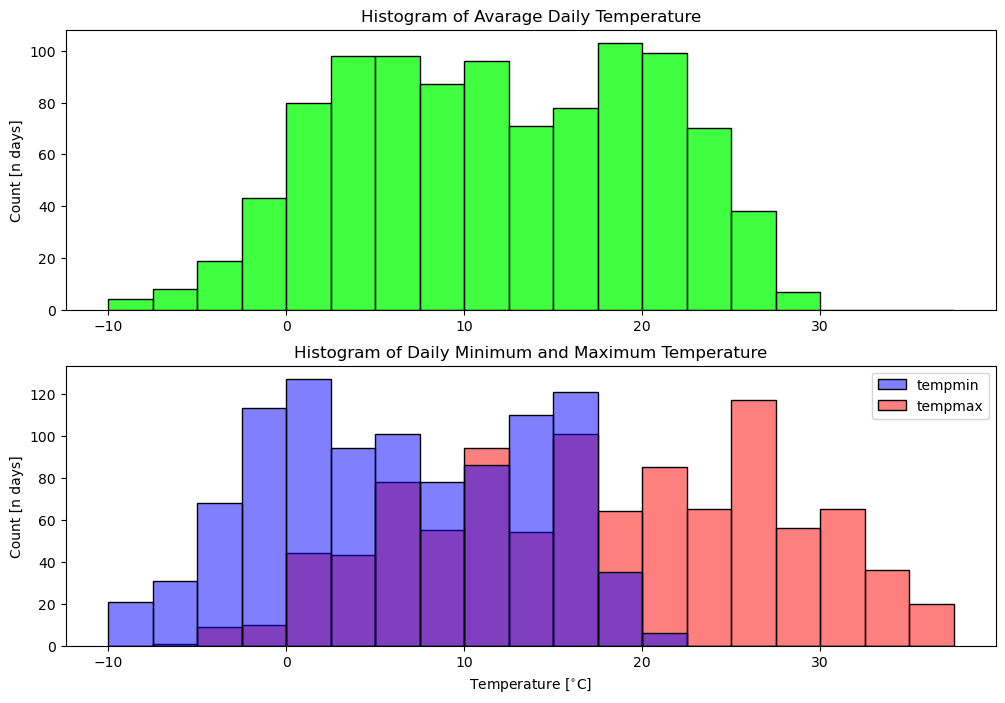

In [19]:
plot_temp_histograms(sofia_weather_data, binrange = [-10, 36])

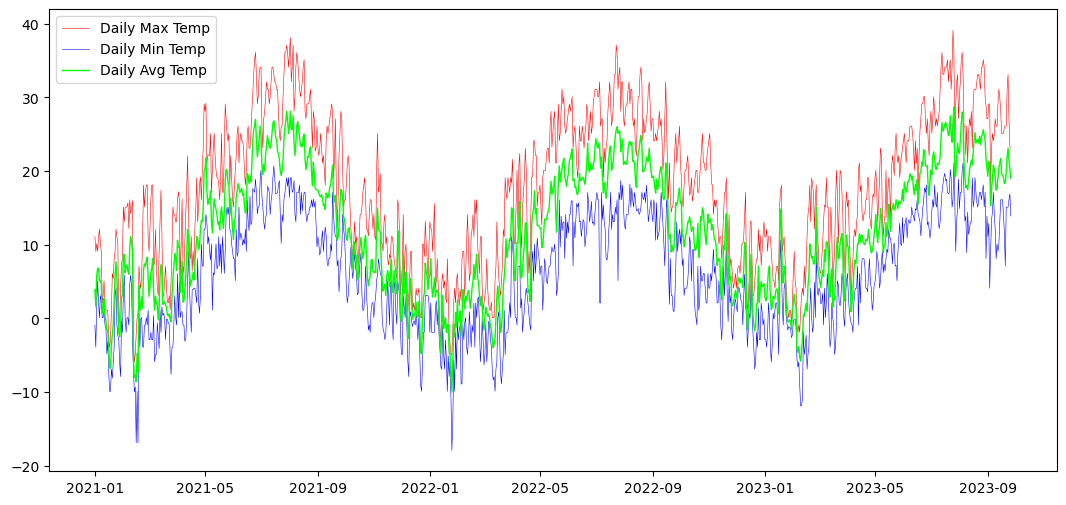

In [20]:
plot_temperatures(sofia_weather_data)

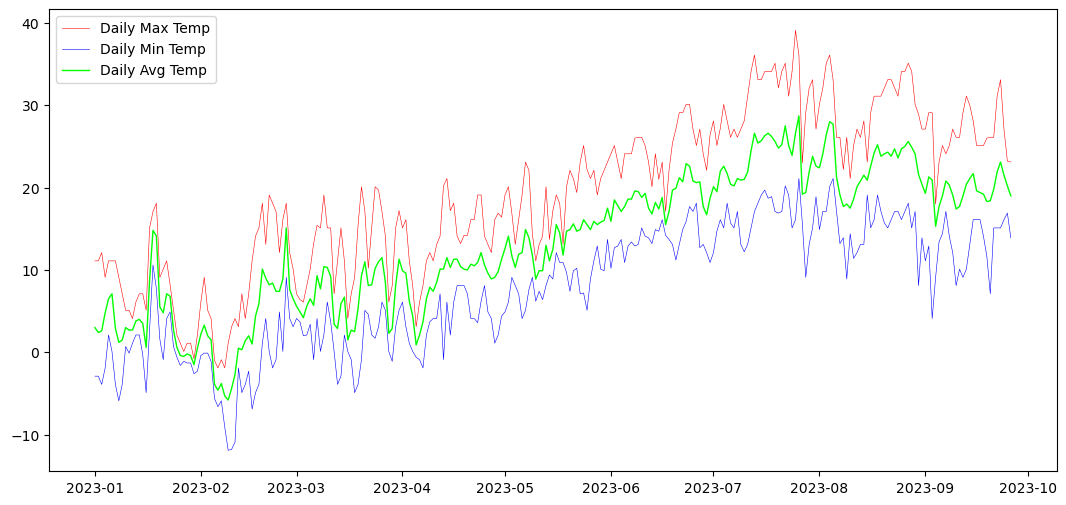

In [21]:
plot_temperatures(sofia_weather_data[sofia_weather_data.datetime.dt.year==2023])

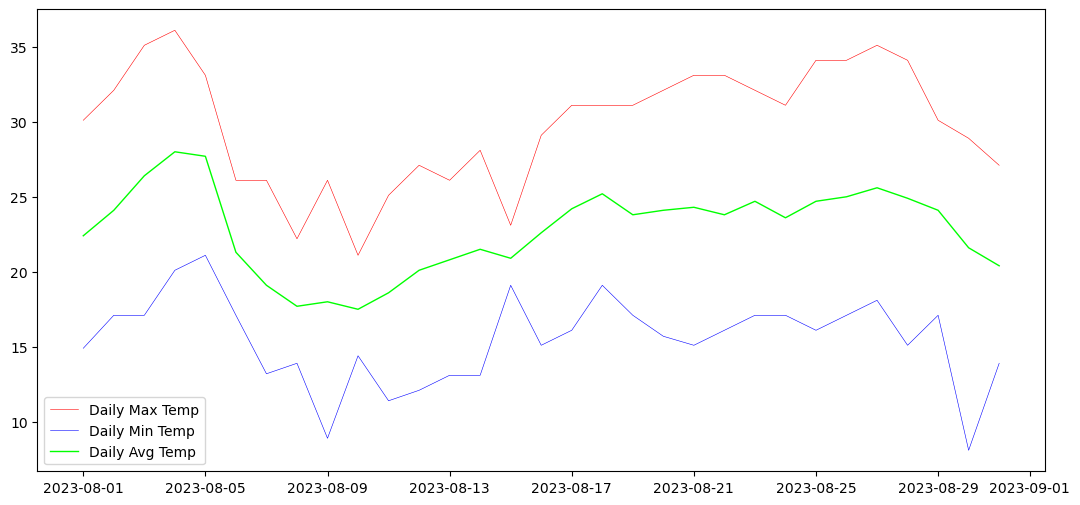

In [22]:
plot_temperatures(sofia_weather_data[(sofia_weather_data.datetime.dt.year==2023) & (sofia_weather_data.datetime.dt.month == 8)])

We plot the avarege daily temperature by year, looking for patterns:

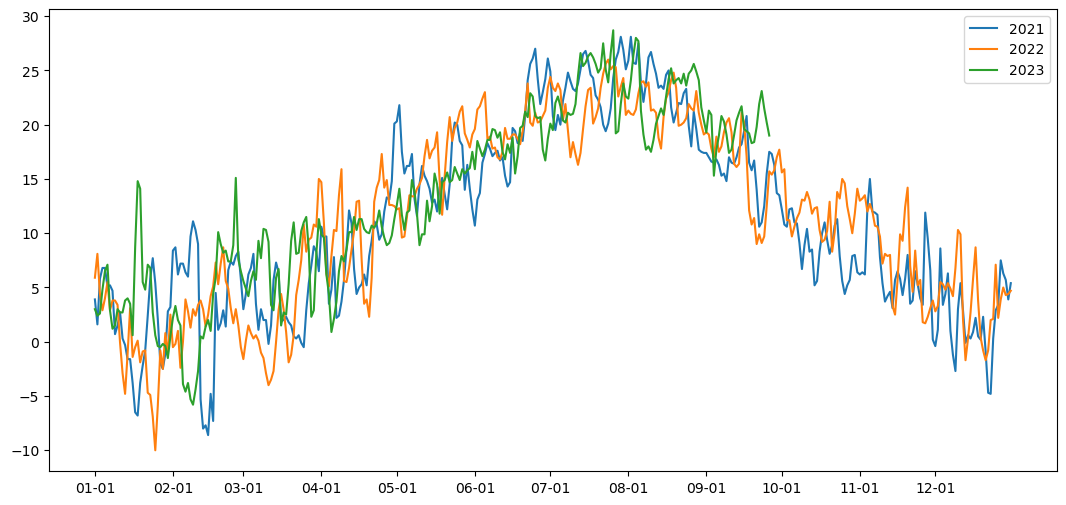

In [23]:
plot_temp_by_year(sofia_weather_data)

```Dew```

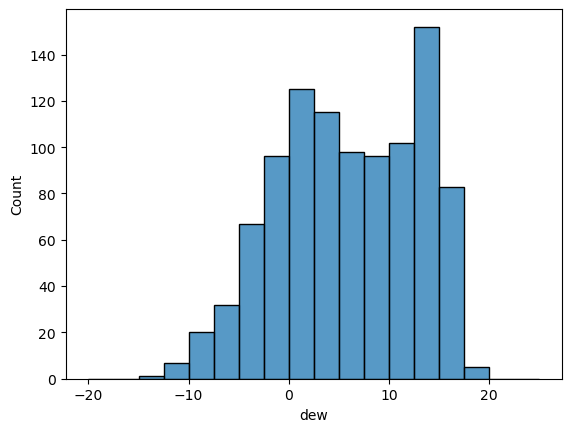

In [24]:
sns.histplot(sofia_weather_data.dew, binwidth = 2.5, binrange = [-20, 25])
plt.show()

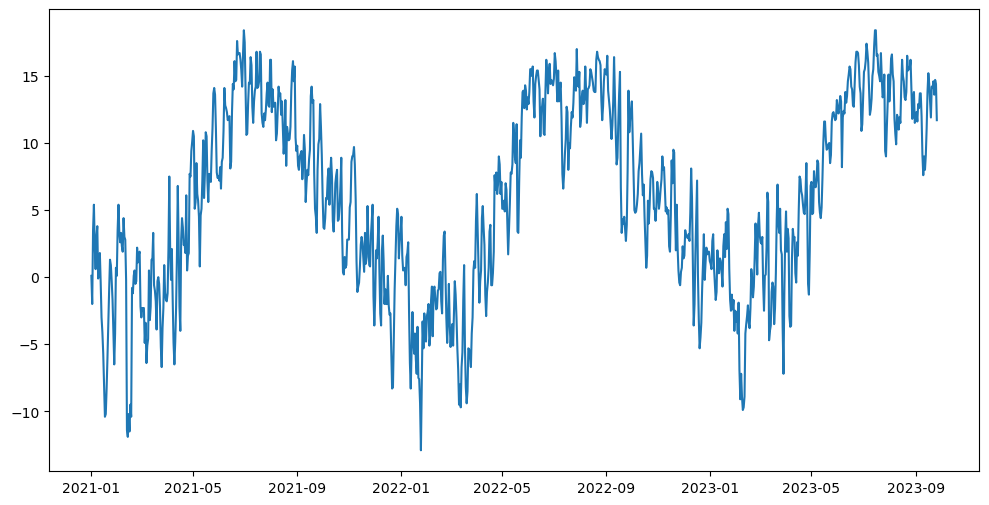

In [25]:
plot_time_series(sofia_weather_data, "dew")

```Humidity```

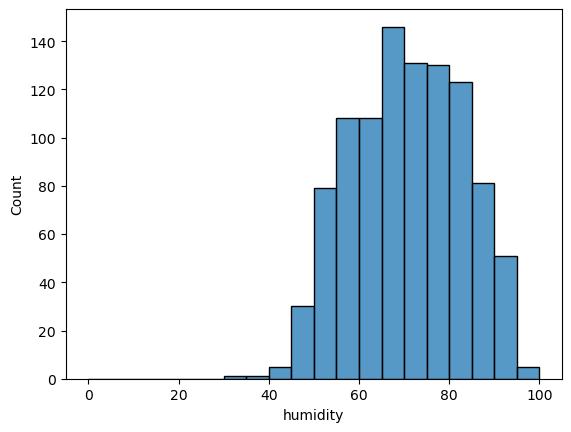

In [26]:
sns.histplot(sofia_weather_data.humidity, binwidth = 5, binrange = [0, 100])
plt.show()

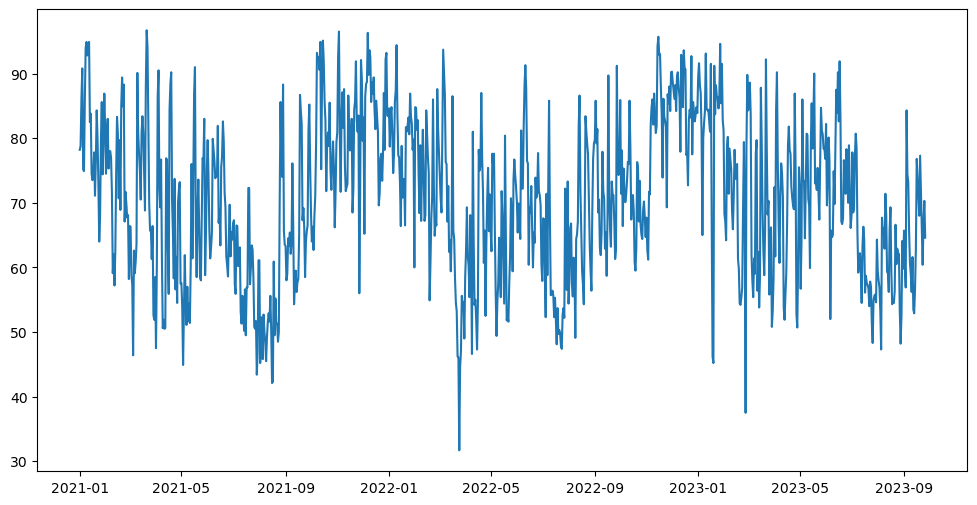

In [27]:
plot_time_series(sofia_weather_data, "humidity")

```precip```

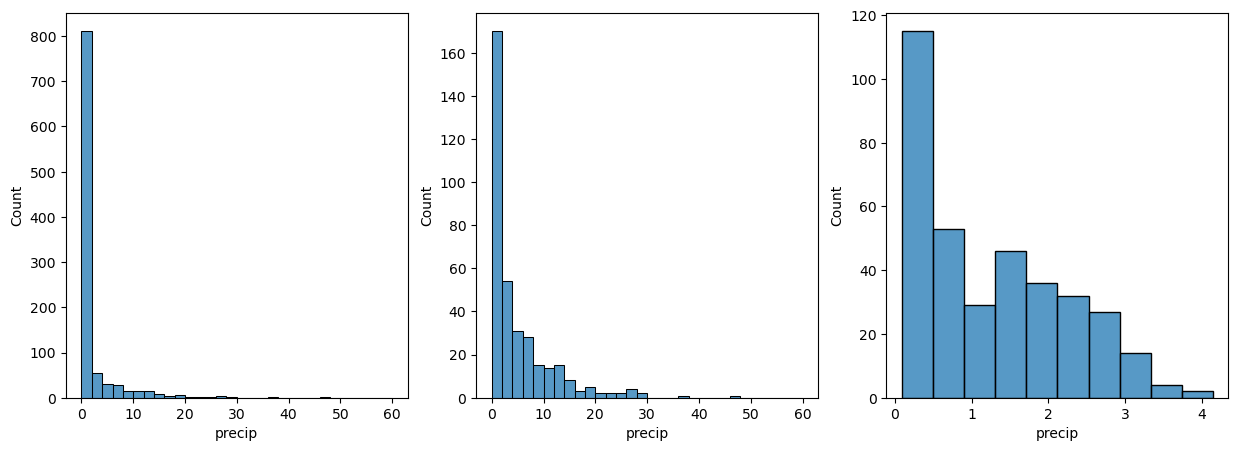

In [28]:
plot_histograms_log_transform(sofia_weather_data, "precip")

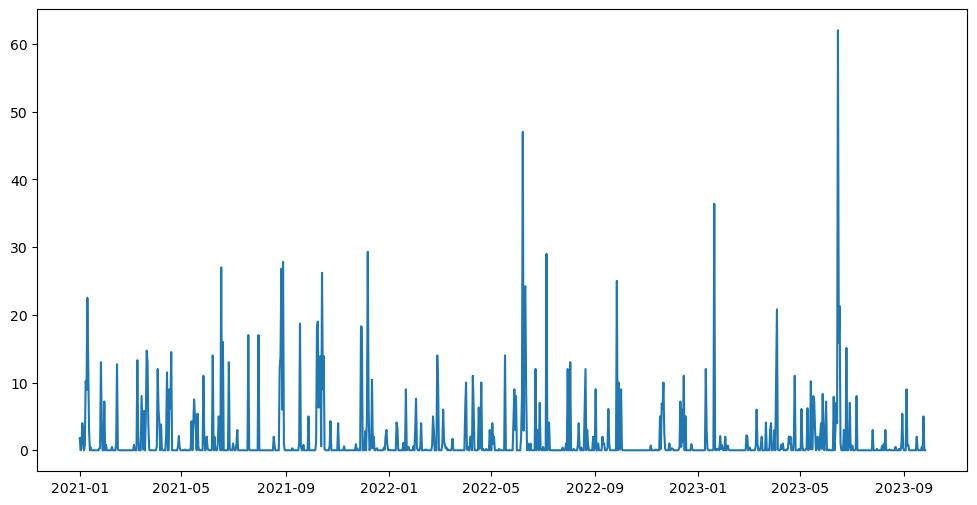

In [29]:
plot_time_series(sofia_weather_data, "precip")

In [30]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
# sns.histplot(sofia_weather_data.precip, ax = ax1, binwidth = 2, binrange = [0, 60])
# sns.histplot(sofia_weather_data.precip[sofia_weather_data.precip > 0], ax = ax2, binwidth = 2, binrange = [0, 60])
# sns.histplot(np.log1p(sofia_weather_data.precip[sofia_weather_data.precip > 0]), ax = ax3)

# plt.show()

```preciptype```

In [31]:
sofia_weather_data.preciptype.value_counts(dropna = False)

preciptype
NaN          641
rain         281
rain,snow     67
snow          10
Name: count, dtype: int64

In [32]:
sofia_weather_data[(sofia_weather_data.precip == 0) & (sofia_weather_data.preciptype.isna())].shape

(641, 19)

In [33]:
sofia_weather_data.preciptype.str.get_dummies(sep=",")

,rain,snow
0,1,1
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
994,1,0
995,0,0
996,1,0
997,0,0


`snow`

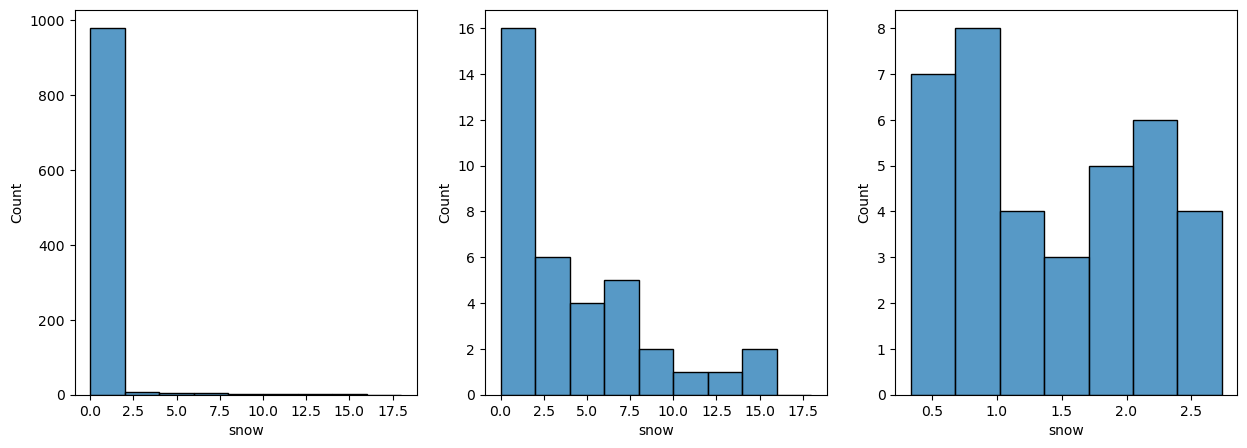

In [34]:
plot_histograms_log_transform(sofia_weather_data, "snow", binrange= [0, 18])

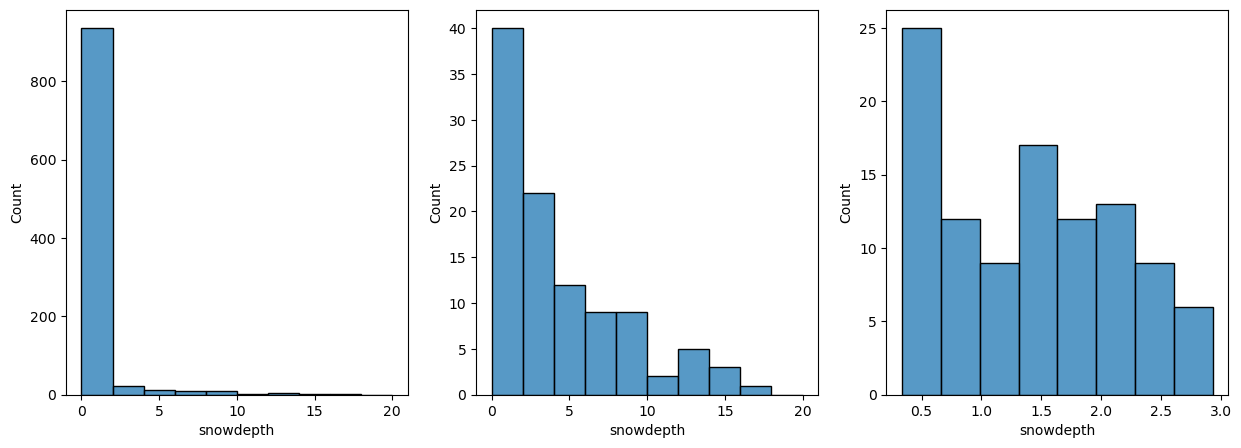

In [35]:
plot_histograms_log_transform(sofia_weather_data, "snowdepth", binrange= [0, 20])

In [36]:
sofia_weather_data.columns

Index(['datetime', 'tempmax', 'tempmin', 'temp', 'dew', 'humidity', 'precip',
       'precipcover', 'preciptype', 'snow', 'snowdepth', 'windgust',
       'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility',
       'conditions', 'description'],
      dtype='object')

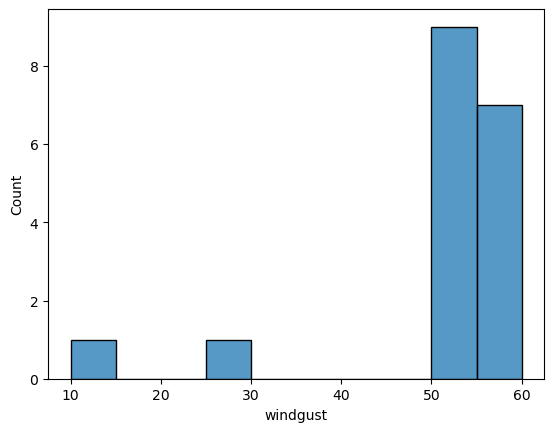

In [37]:
sns.histplot(sofia_weather_data.windgust, binwidth = 5, binrange = [10, 60])
plt.show()

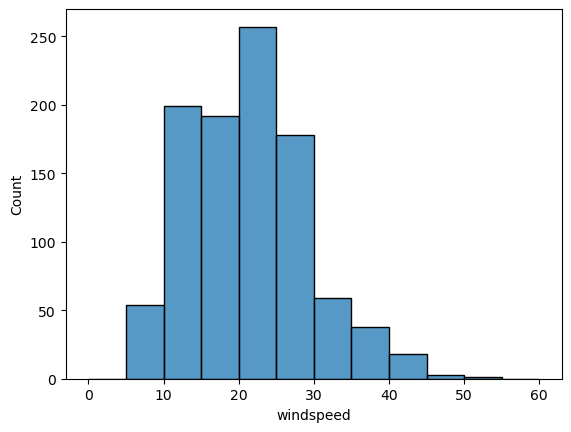

In [38]:
sns.histplot(sofia_weather_data.windspeed, binwidth = 5, binrange = [0, 60])
plt.show()

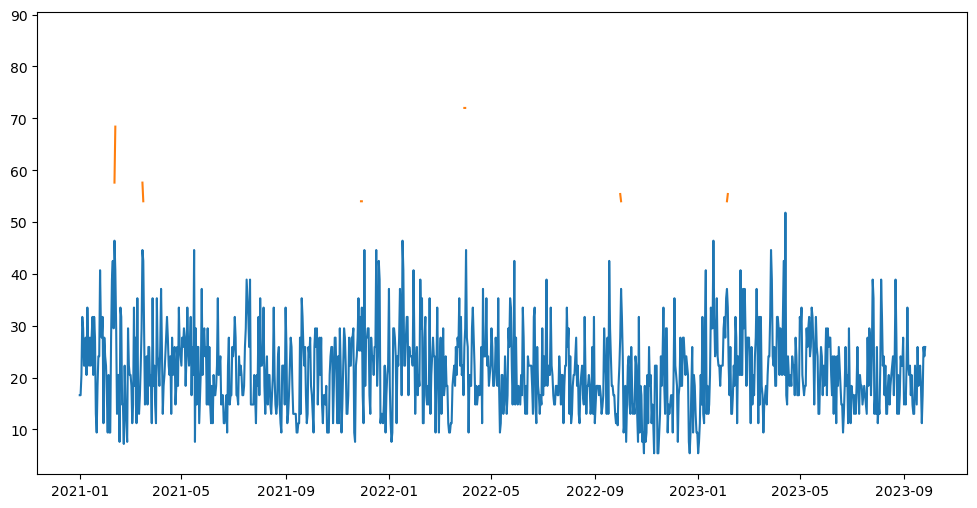

In [39]:
plot_time_series(sofia_weather_data, ["windspeed", "windgust"])

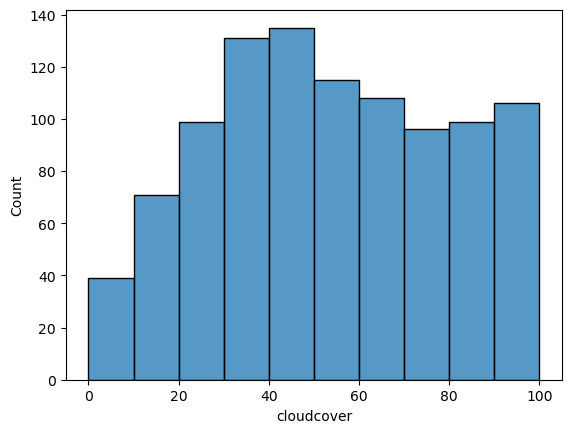

In [40]:
sns.histplot(sofia_weather_data.cloudcover, binwidth=10, binrange=[0,100])
plt.show()

In [41]:
sofia_weather_data.cloudcover[sofia_weather_data.cloudcover < 5]

56     0.0
57     2.2
85     4.3
219    0.0
276    4.0
447    0.0
450    1.4
467    2.5
468    0.0
559    1.4
566    4.0
567    1.4
669    0.0
770    3.0
771    2.7
Name: cloudcover, dtype: float64

In [42]:
sofia_weather_data.cloudcover.isna().sum()

0

In [43]:
sofia_weather_data.conditions[sofia_weather_data.cloudcover.isna()]

Series([], Name: conditions, dtype: object)

In [44]:
sofia_weather_data.conditions.value_counts(dropna = False)

conditions
Partially cloudy                506
Rain, Partially cloudy          236
Clear                           115
Rain, Overcast                   43
Snow, Rain, Overcast             39
Snow, Rain, Partially cloudy     28
Overcast                         20
Snow, Partially cloudy            7
Snow, Overcast                    3
Rain                              2
Name: count, dtype: int64

In [45]:
sofia_weather_data.conditions.str.get_dummies(sep=",")

,Overcast,Partially cloudy,Rain,Clear,Overcast,Partially cloudy,Rain,Snow
0,0,1,1,0,0,0,0,1
1,0,0,0,1,0,0,0,0
2,0,1,0,0,0,0,1,0
3,1,0,0,0,0,0,1,0
4,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
994,0,1,0,0,0,0,1,0
995,0,0,0,0,0,1,0,0
996,0,1,0,0,0,0,1,0
997,0,0,0,0,0,1,0,0


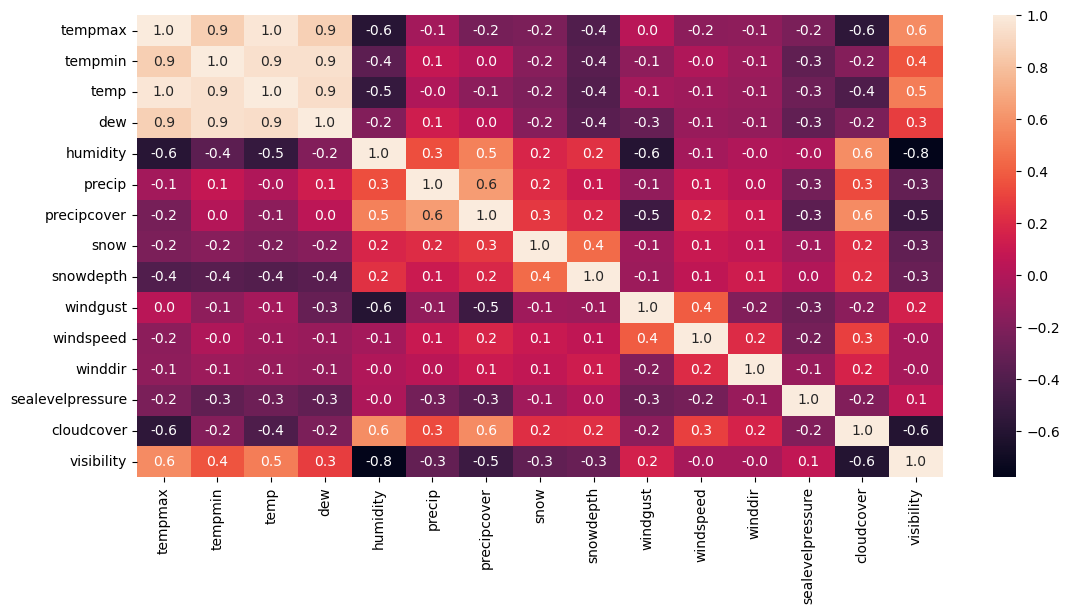

In [46]:
plt.figure(figsize=(13, 6))
sns.heatmap(sofia_weather_data.corr(numeric_only = True), annot=True, fmt=".1f")
plt.show()

In [47]:
acf(sofia_weather_data.temp)

array([1.        , 0.96455466, 0.92346839, 0.89399754, 0.87437496,
       0.86171057, 0.85307001, 0.84744816, 0.84023534, 0.83226234,
       0.82376197, 0.81598765, 0.81278821, 0.81117029, 0.80678271,
       0.79984089, 0.79325587, 0.78473679, 0.77373283, 0.7650513 ,
       0.75888348, 0.75428286, 0.75095523, 0.74520119, 0.73810511,
       0.73157994, 0.72340231, 0.7197608 , 0.71875982, 0.71574726])

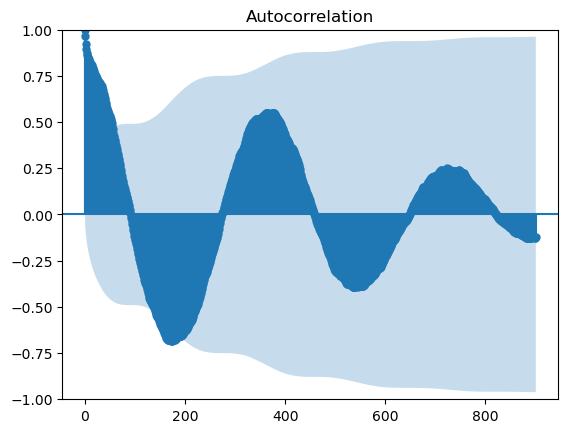

In [48]:
plot_acf(sofia_weather_data.temp, lags = 900)
plt.show()

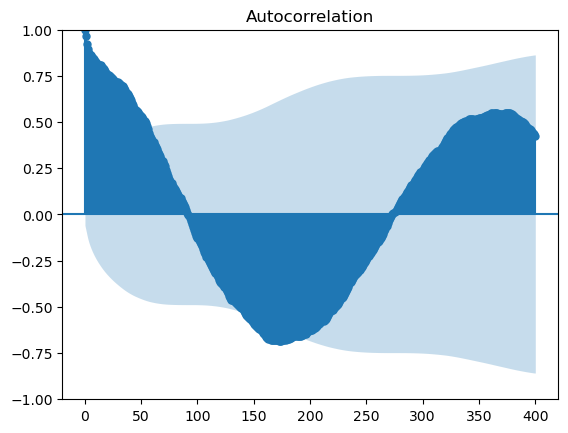

In [49]:
plot_acf(sofia_weather_data.temp, lags = 400)
plt.show()

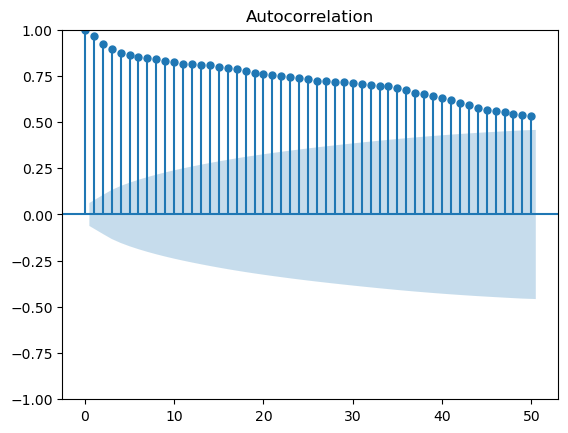

In [50]:
plot_acf(sofia_weather_data.temp, lags = 50)
plt.show()

C:\Users\diana\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


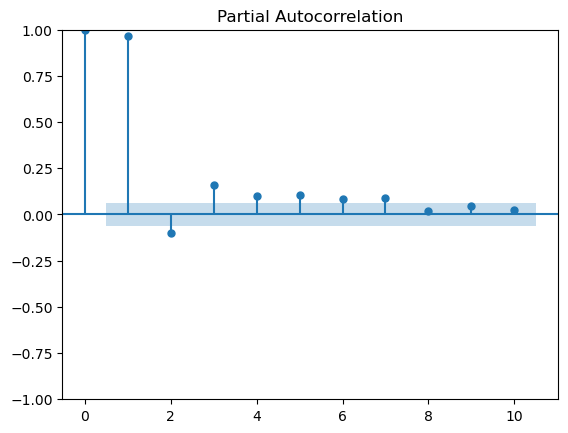

In [51]:
plot_pacf(sofia_weather_data.temp, lags = 10)
plt.show()

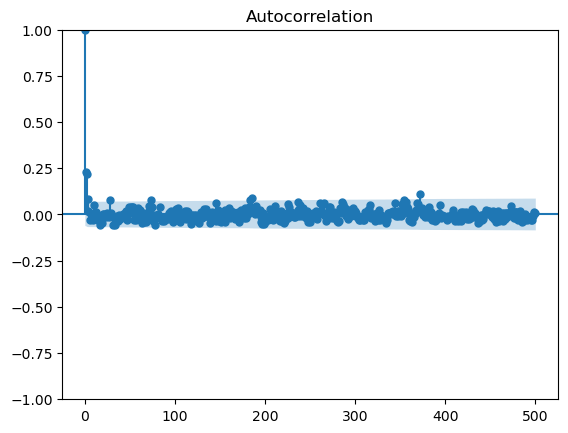

In [52]:
plot_acf(sofia_weather_data.precip, lags = 500)
plt.show()

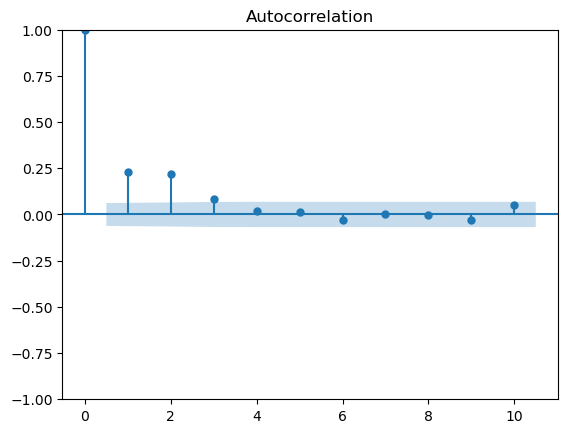

In [53]:
plot_acf(sofia_weather_data.precip, lags = 10)
plt.show()

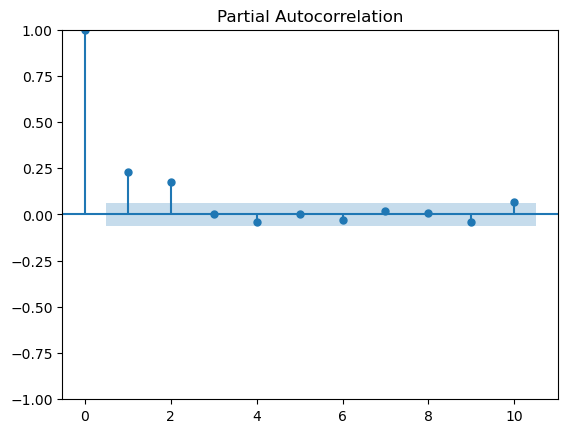

In [54]:
plot_pacf(sofia_weather_data.precip, lags = 10)
plt.show()

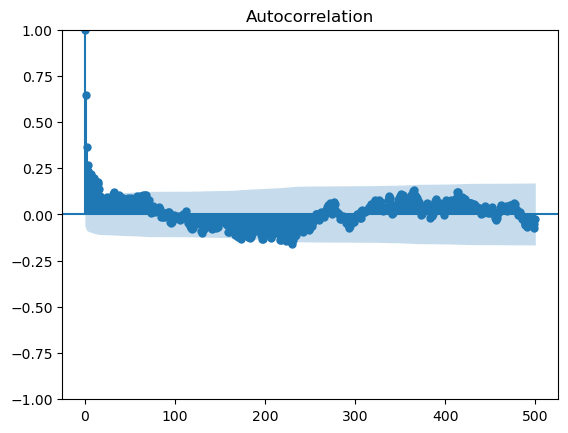

In [55]:
plot_acf(sofia_weather_data.cloudcover, lags = 500)
plt.show()

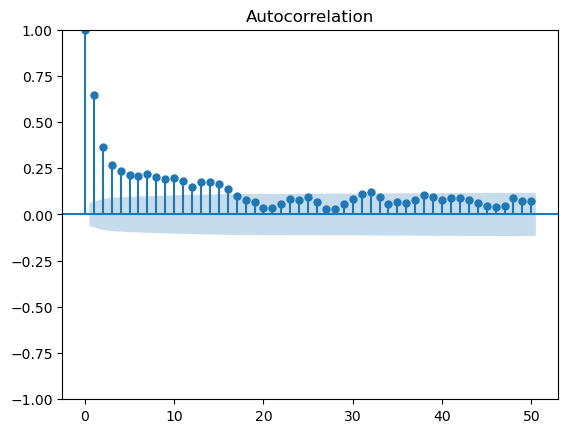

In [56]:
plot_acf(sofia_weather_data.cloudcover, lags = 50)
plt.show()

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [58]:
sofia_weather_data = sofia_weather_data.set_index("datetime")

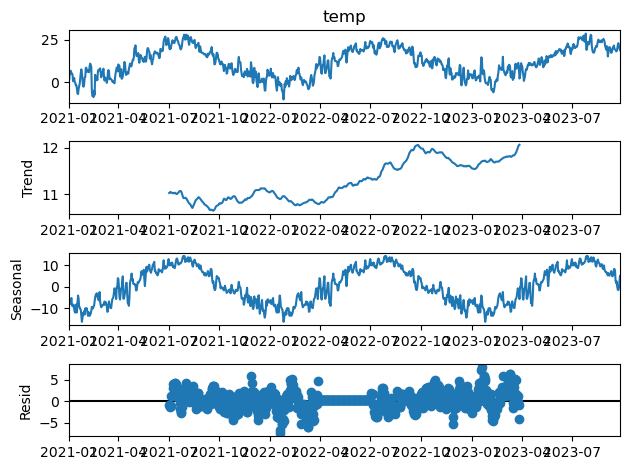

In [59]:
decomposition = seasonal_decompose(sofia_weather_data.temp, period = 365)
decomposition.plot()
plt.show()

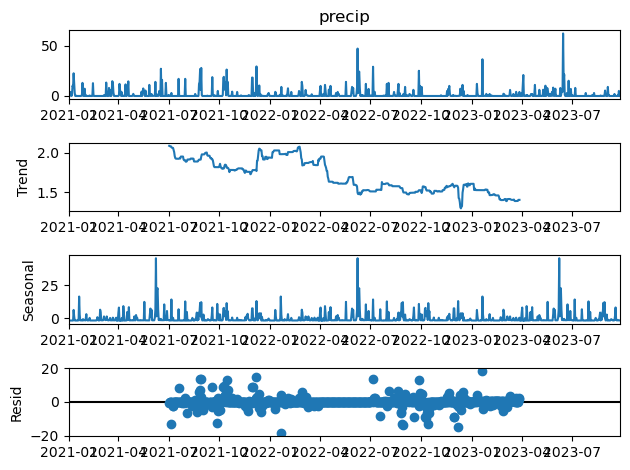

In [60]:
decomposition = seasonal_decompose(sofia_weather_data.precip, period = 365)
decomposition.plot()
plt.show()

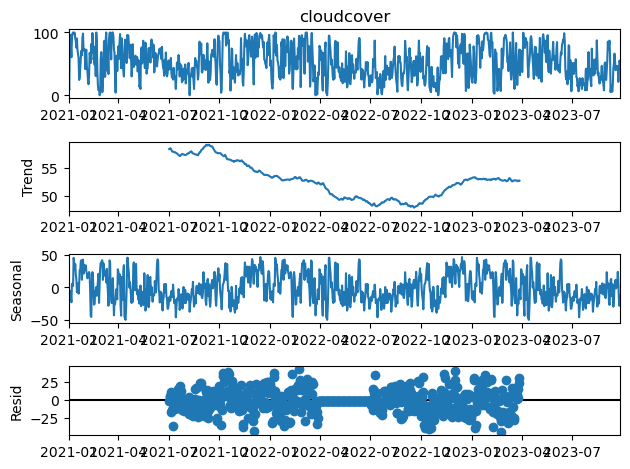

In [61]:
decomposition = seasonal_decompose(sofia_weather_data.cloudcover, period = 365)
decomposition.plot()
plt.show()